In [1]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
#Impute
train_data["fuel_type"].fillna("Electric" , inplace=True)
test_data["fuel_type"].fillna("Electric" , inplace=True)
mode_value_1 = train_data["clean_title"].mode()[0]
mode_value_2 = train_data["accident"].mode()[0]
mode_value_3 = train_data["clean_title"].mode()[0]
mode_value_4 = test_data["accident"].mode()[0]
train_data["clean_title"].fillna(mode_value_1 , inplace= True)
train_data["accident"].fillna(mode_value_1 , inplace= True)
test_data["clean_title"].fillna(mode_value_3 , inplace=True)
test_data["accident"].fillna(mode_value_4 , inplace=True)
train_data.drop(["clean_title"] , axis= 1 , inplace=True)
test_data.drop(["clean_title"] , axis= 1 , inplace=True)





C:\Users\TRITON\AppData\Local\Temp\ipykernel_4944\3427293591.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data["fuel_type"].fillna("Electric" , inplace=True)
C:\Users\TRITON\AppData\Local\Temp\ipykernel_4944\3427293591.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [23]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

objects = ['brand', 'model', 'fuel_type', 
            'transmission', 'ext_col', 'int_col',
            'accident']
for col in objects:
    le = LabelEncoder()
    combined = pd.concat([train_data[col], test_data[col]], axis=0).astype(str)
    le.fit(combined)
    train_data[col] = le.transform(train_data[col].astype(str))
    test_data[col] = le.transform(test_data[col].astype(str))

In [24]:
x_train = train_data.drop(["price"] , axis=1)
y_train = train_data["price"]

In [25]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(x_train , y_train , random_state=42)
mi_scores = pd.DataFrame({
    "Features" : x_train.columns,
    "mi_scores" : mi_scores
}).sort_values("mi_scores",ascending=False)

In [26]:
print(mi_scores)

       Features  mi_scores
3        milage   0.680223
2    model_year   0.554712
5  transmission   0.440795
1         model   0.287399
6       ext_col   0.148855
0         brand   0.142635
7       int_col   0.123513
8      accident   0.063297
4     fuel_type   0.030676


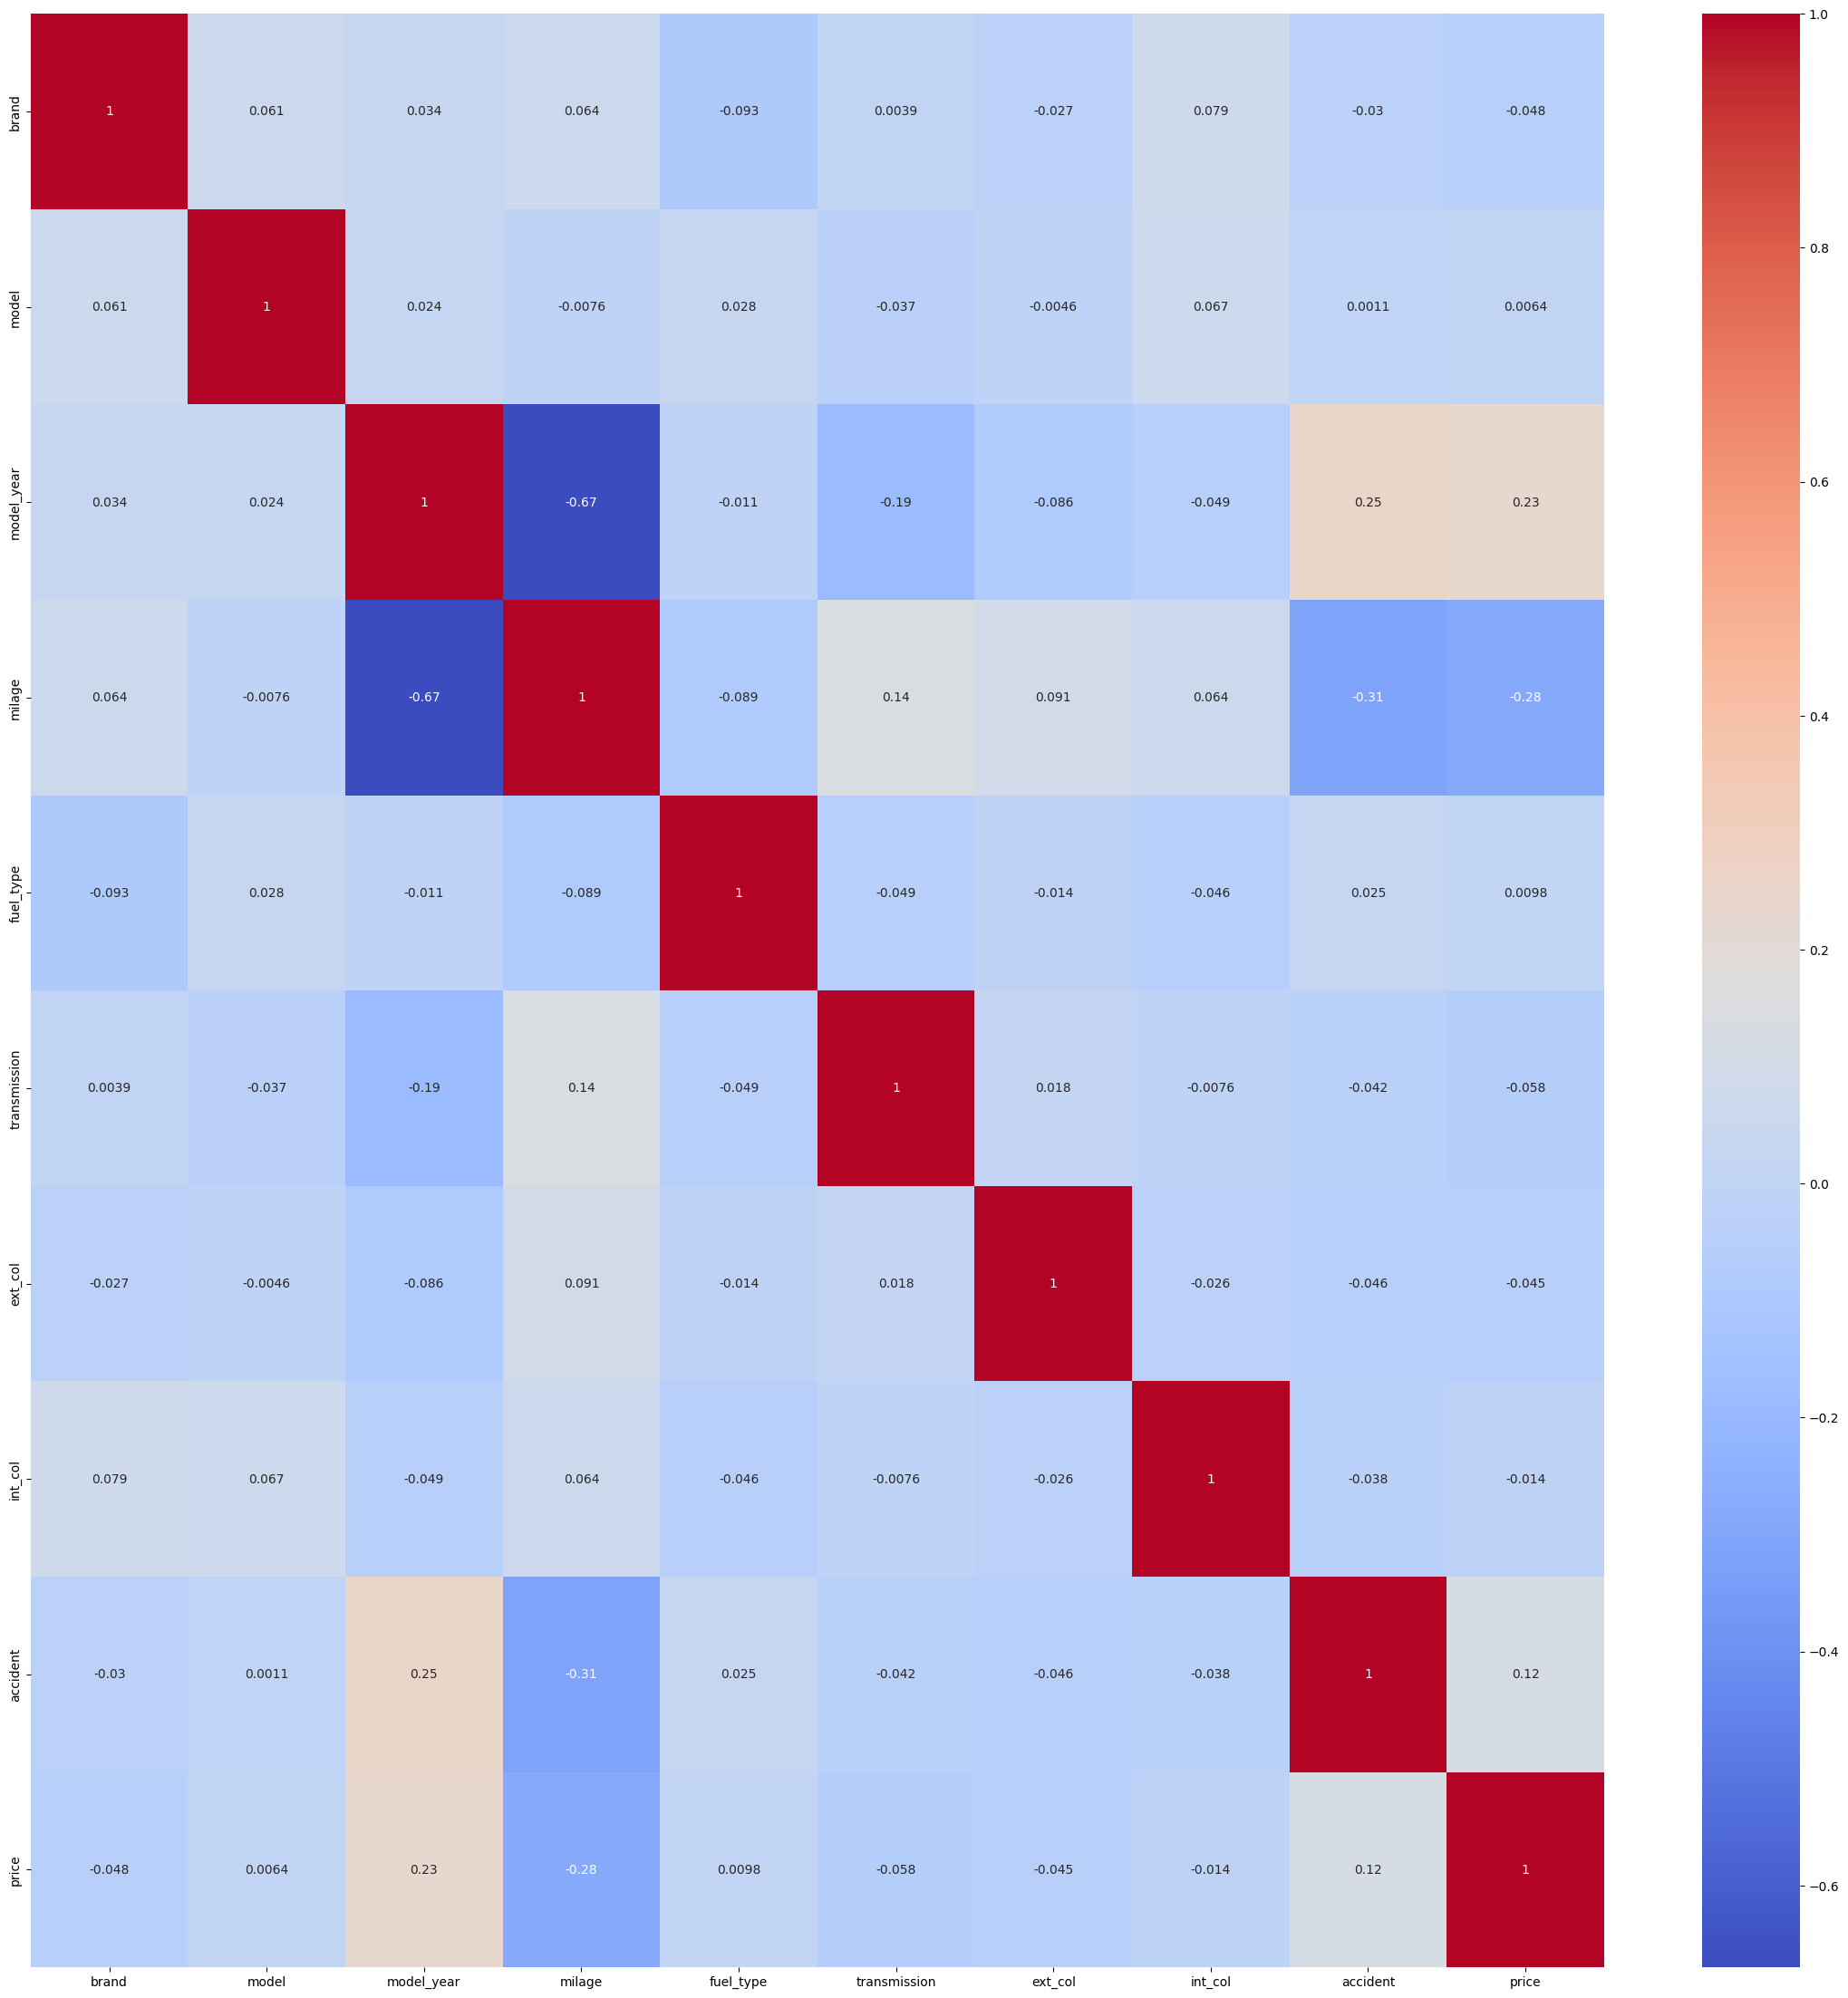

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = train_data.corr(numeric_only=True)
plt.figure(figsize=(28 , 28))
sns.heatmap(corr_matrix  , annot=True , cmap="coolwarm")
plt.show()

In [30]:
x_train = train_data.drop(["price"] , axis= 1 , inplace= False)
y_train = train_data["price"]

In [39]:
#Baseline model 
import xgboost as xgb
import numpy as np

baseline_Model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    min_child_weight=5,
    learning_rate=0.05,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

baseline_Model.fit(x_train , y_train , verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

base_prediction = baseline_Model.predict(x_train)
mse_error = mean_squared_error(y_train , base_prediction)
rmse_error = np.sqrt(mse_error)
cv_score = cross_val_score(baseline_Model,x_train , y_train , scoring="neg_mean_squared_error" , cv=3 , n_jobs=-1)
tv_score = np.sqrt(-cv_score)
print(f"The RMSE error is: {rmse_error}")
print(f"The cross value score is {tv_score.mean()}")

The RMSE error is: 61124.42706479955
The cross value score is 74781.52586643664


In [42]:
test_predict = baseline_Model.predict(test_data)

In [43]:
t = pd.read_csv("test.csv")

submisson = pd.DataFrame({
    "id" : t["id"],
    "price" : test_predict
})

submisson.to_csv("submisson.csv" , index=False)